# Implementasi Auto Machine Learning menggunakan NiaPy
NiaPy menyediakan sebuah interface untuk menyelesaikan permaslahan optimasi dengan memanfaatkan evolutionary algorithm. Dalam implementasi ini, permasalahan yang diangkat adalah membuat sebuah model klasifikasi. Dengan begitu, permasalahan optimasi yang dihadapi adalah bagaimana cara meminimalkan kesalahan (error). 

Atha Ahsan Xavier Haris (1301210045)
Deaz Setyo Nugroho (1301210248)
Stefhan Salim (1301210529)
Valent Fauzan Al Rasyid (1301213194)

Tautan Presentasi: https://youtu.be/nKLCLoNhprc

## Data Loading

In [1]:
import openml
# This is done based on the dataset ID.
dataset = openml.datasets.get_dataset(43571)

# Print a summary
print(f"This is dataset '{dataset.name}', the target feature is `Wine`")
print(f"URL: {dataset.url}")
print(dataset.description[:500])

C:\Users\wwwvf\AppData\Local\Temp\ipykernel_7612\764238655.py:3: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(43571)


This is dataset 'WineDataset', the target feature is `Wine`
URL: https://api.openml.org/data/v1/download/22102396/WineDataset.arff
These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.
I think that the initial data set had around 30 variables, but for some reason I only have the 13 dimensional version. I had a list of what the 30 or so variables were, but a.) I lost it, and b.), I would not know which 13 variables are included in the set.
The 


In [2]:
df, *_ = dataset.get_data()
df.head()

,Alcohol,Malic_Acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline,Wine
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,1


array([[<Axes: xlabel='Alcohol', ylabel='Alcohol'>,
        <Axes: xlabel='Malic_Acid', ylabel='Alcohol'>,
        <Axes: xlabel='Ash', ylabel='Alcohol'>,
        <Axes: xlabel='Alcalinity_of_ash', ylabel='Alcohol'>,
        <Axes: xlabel='Magnesium', ylabel='Alcohol'>,
        <Axes: xlabel='Total_phenols', ylabel='Alcohol'>,
        <Axes: xlabel='Flavanoids', ylabel='Alcohol'>,
        <Axes: xlabel='Nonflavanoid_phenols', ylabel='Alcohol'>,
        <Axes: xlabel='Proanthocyanins', ylabel='Alcohol'>,
        <Axes: xlabel='Color_intensity', ylabel='Alcohol'>,
        <Axes: xlabel='Hue', ylabel='Alcohol'>,
        <Axes: xlabel='OD280/OD315_of_diluted_wines', ylabel='Alcohol'>,
        <Axes: xlabel='Proline', ylabel='Alcohol'>],
       [<Axes: xlabel='Alcohol', ylabel='Malic_Acid'>,
        <Axes: xlabel='Malic_Acid', ylabel='Malic_Acid'>,
        <Axes: xlabel='Ash', ylabel='Malic_Acid'>,
        <Axes: xlabel='Alcalinity_of_ash', ylabel='Malic_Acid'>,
        <Axes: xlabel='Magne

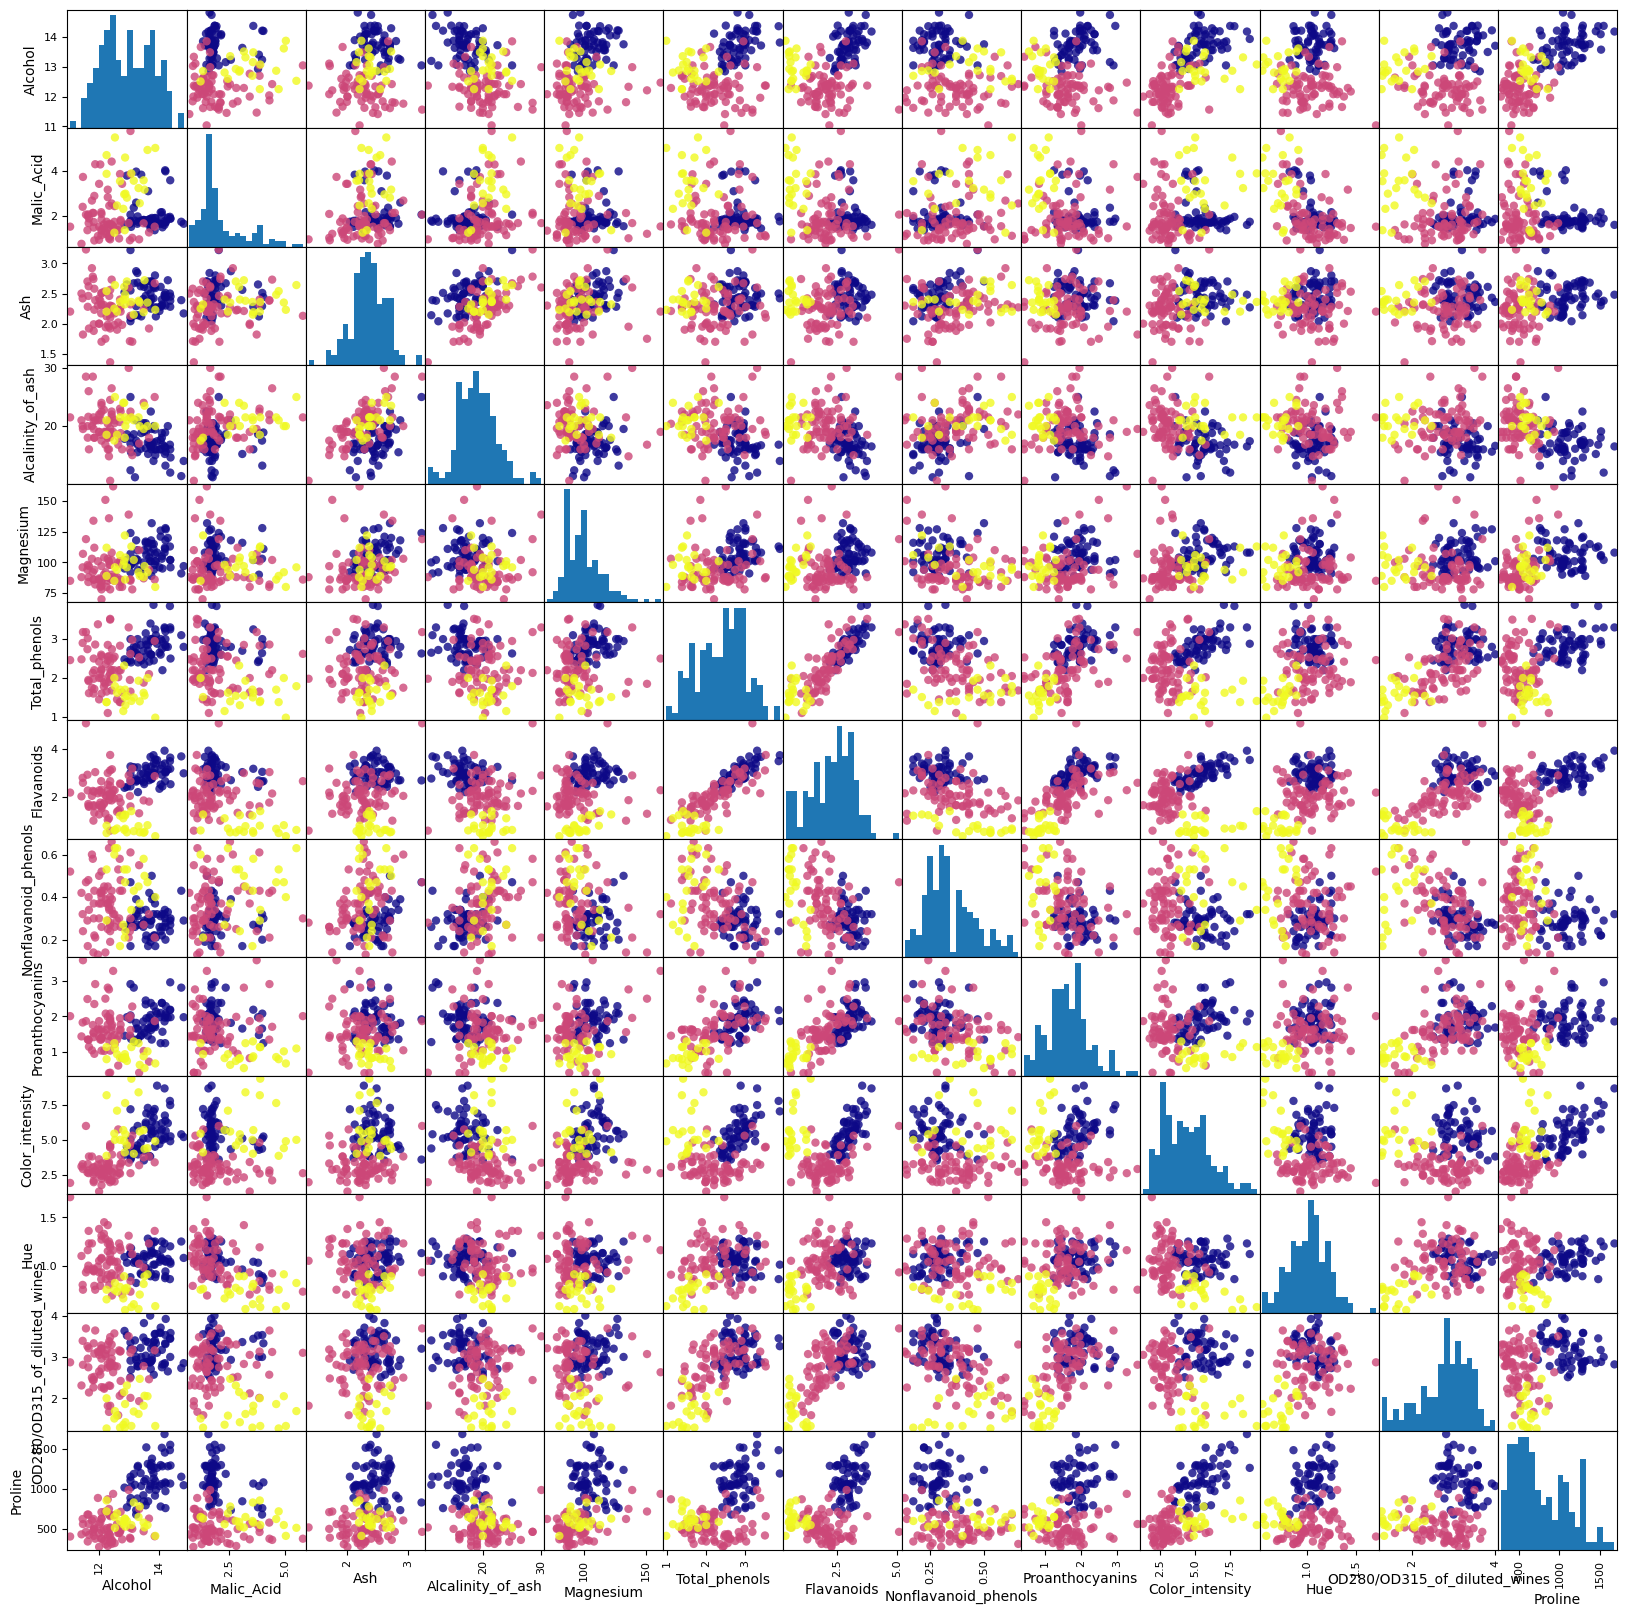

In [3]:
import pandas as pd
X, y, categorical_indicator, attribute_names = dataset.get_data(target="Wine")

pd.plotting.scatter_matrix(
    df.iloc[:150, :13],
    c=y[:150],
    figsize=(20, 20),
    marker="o",
    hist_kwds={"bins": 20},
    alpha=0.8,
    cmap="plasma",
)

## Data Preprocessing

In [4]:
# Check for null values
df.isnull().sum()

Alcohol                         0
Malic_Acid                      0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
OD280/OD315_of_diluted_wines    0
Proline                         0
Wine                            0
dtype: int64

## Data Splitting

In [5]:
from sklearn.model_selection import train_test_split

df = df.reset_index(drop=True)

# Split Data (training: 70%, testing: 30%)
X = df.drop(columns='Wine')
y = df['Wine']
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size =0.3,random_state=42)

## Custom Problem Definition
Mari kita coba melakukan optimasi untuk mencari parameter terbaik untuk model Random Forest (RF). Kali ini, parameter yang akan dijadikan search space dalam PSO adalah kedalaman maksimal dari setiap tree dalam RF dan banyaknya DecisionTree yang digunakan dalam RF

In [11]:
from niapy.task import Task
from niapy.problems import Problem
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# our custom Problem class
class MyProblem(Problem):
    def __init__(self, dimension=2, lower=1, upper=10, *args, **kwargs):
        super().__init__(dimension, lower, upper, *args, **kwargs)

    def _evaluate(self, x):
        # Make sklearn model here
        model = RandomForestClassifier(n_estimators= int(x[0]), max_depth=int(x[1]))
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        return accuracy_score(Y_test, predictions)
        # return np.sum(x ** 2)

## Run the Optimizer

In [26]:
from niapy.algorithms.basic import ParticleSwarmAlgorithm
from niapy.task import OptimizationType
my_problem = MyProblem(dimension=2)

task = Task(problem=my_problem, max_iters=5, optimization_type=OptimizationType.MAXIMIZATION)
algorithm = ParticleSwarmAlgorithm(population_size=100, w=0.9, c1=0.5, c2=0.3, min_velocity=-1, max_velocity=1)

# running algorithm returns best found minimum
best_x, best_fit = algorithm.run(task)
print(f"Konfigurasi terbaik: {int(best_x[0])} pohon dengan kedalaman maksimal tiap pohon {int(best_x[1])}")

# Test the x obtained from PSO
model = RandomForestClassifier(n_estimators= int(best_x[0]), max_depth=int(best_x[1]))
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
print(confusion_matrix(Y_test, predictions))
print(accuracy_score(Y_test, predictions))


Konfigurasi terbaik: 9 pohon dengan kedalaman maksimal tiap pohon 7
[[19  0  0]
 [ 1 19  1]
 [ 0  1 13]]
0.9444444444444444
